    Compute the sift-keypoints and descriptors for both the images.
    Compute distances between every descriptor in one image and every descriptor in the other image.
    Select the top ‘m’ matches for each descriptor of an image.
    Run RANSAC to estimate homography
    Warp to align for stitching
    Now stitch them together

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### reading both images and converting into grayscale

In [23]:
img_ = cv2.imread('rightone.png')
img_ = cv2.resize(img_, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)

img = cv2.imread('leftone.png')
img = cv2.resize(img, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#### using sift to extract keypoints and sift descriptors

In [24]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [25]:
#showing the keypoints on the images

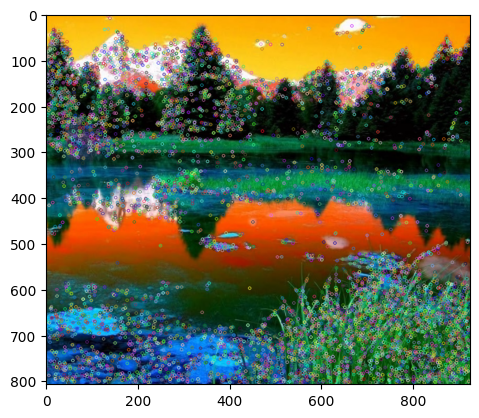

In [26]:
plt.imshow(cv2.drawKeypoints(img_,kp1,None))

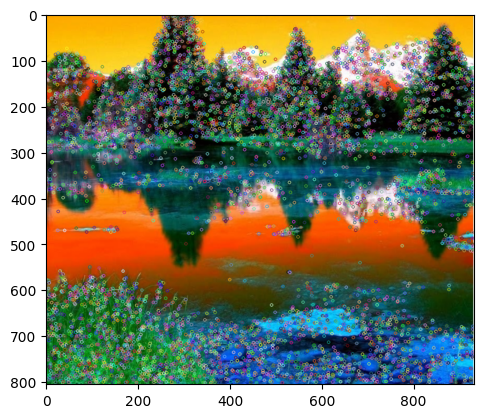

In [27]:
plt.imshow(cv2.drawKeypoints(img,kp2,None))

#### use brute force matcher to match features that are similar
parameter k=2, we are asking the knnMatcher to give out 2 best matches for each descriptor

In [28]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

### since there is a chance that features may exist in many places of the image, and that may be misleading in some cases. so we can set a threshold to obtain the best matches

In [29]:
good = []
for m,n in matches:
    if m.distance < 0.05*n.distance:
        good.append(m)

#### displaying the features matched between both images

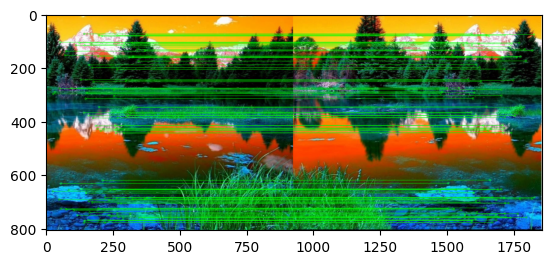

In [30]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img_,kp1,img,kp2,good,None,**draw_params)
#"original_image_drawMatches.jpg",
plt.imshow(img3)

### computing the homography 

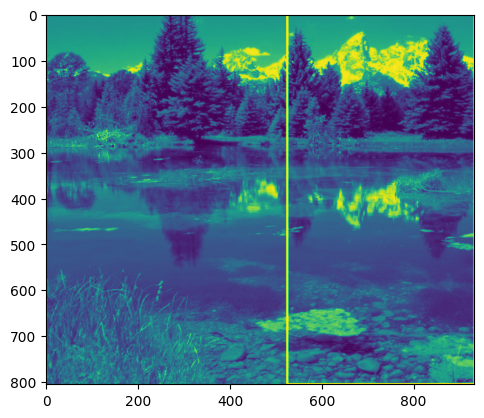

In [31]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    #"original_image_overlapping.jpg",
    plt.imshow( img2)
else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

In [32]:
dst = cv2.warpPerspective(img_,M,(img.shape[1] + img_.shape[1], img.shape[0]))
dst[0:img.shape[0], 0:img.shape[1]] = img

#### trim function to adjust the final image

In [35]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-1])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-1])    
    return frame

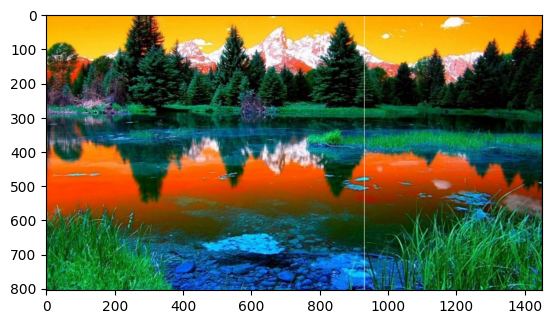

In [36]:
#"original_image_stiched_crop.jpg",
plt.imshow( trim(dst))